In [ ]:
# Import dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
# We can view all of the classes that automap found
Base.classes.keys()

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

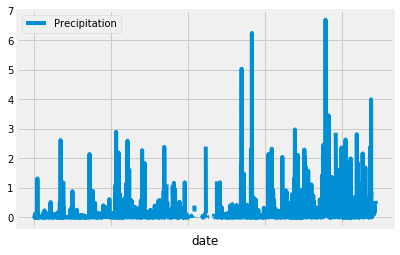

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from today
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data).rename(index=str, columns={"prcp": "Precipitation"}).set_index("date")
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = precip_df.describe()
summary_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
station_data = session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).\
    filter(Measurement.date > year_ago).all()
station_data_df = pd.DataFrame(station_data)
station_data_df = station_data_df.set_index("date")
num_stations = len(station_data_df["station"].unique())
num_stations

7

In [87]:
stations = station_data_df["station"].unique()
station_dict = {"Station Names": list(stations)}
station_dict

{'Station Names': ['USC00519397',
  'USC00513117',
  'USC00514830',
  'USC00517948',
  'USC00519523',
  'USC00519281',
  'USC00516128']}

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_df = station_data_df.groupby("station").count()
active_df = active_df.sort_values("tobs", ascending=False)
active_df

,prcp,tobs
station,,
USC00519397,358,360
USC00519281,351,351
USC00516128,327,348
USC00513117,342,342
USC00519523,313,336
USC00514830,264,304
USC00517948,60,182


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
    filter(Measurement.station == "USC00519397").all()
temp_df = pd.DataFrame(temp_data)
min_temp = temp_df["tobs"].min()
max_temp = temp_df["tobs"].max()
avg_temp = temp_df["tobs"].mean()
values = [min_temp, max_temp, avg_temp]
values

[56.0, 87.0, 74.55323054331865]

Text(0.5,1,'Observed Temperature Frequencies')

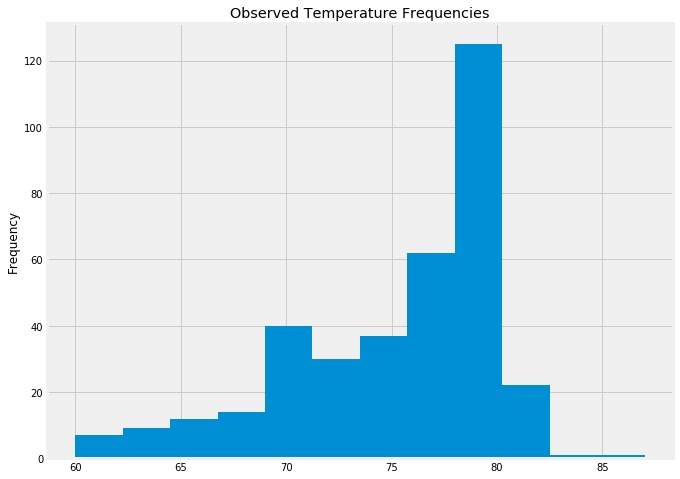

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == "USC00519397").all()
temp_station_df = pd.DataFrame(temp_station)
temp_station_df = pd.DataFrame(temp_station_df).rename(index=str, columns={"tobs": "Temperature"}).set_index("date")
temp_station_df.hist(bins=12, figsize=(10,8))
plt.ylabel("Frequency")
plt.title("Observed Temperature Frequencies")

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-02-28', '2017-03-05')

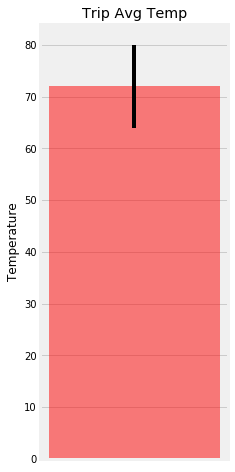

In [77]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(0, temps[0][1], yerr = [((temps[0][1]-temps[0][0]), (temps[0][2]-temps[0][1]))], align='edge', alpha=.5, color='r')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.rcParams["figure.figsize"] = [3,8]
plt.grid(axis='x')

In [81]:
from flask import Flask, jsonify


#################################################
# Database Setup
#################################################
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

#################################################
# Flask Setup
#################################################
app = Flask(__name__)
precip_dict = {}
for data in precip_data:
    precip_dict[data[0]] = data[1]
precip_dict

{'2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': None,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-05': 0.18,
 '2016-09-06': 1.0,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 '2016-10-10': 0.0,
 

In [82]:
#################################################
# Flask Routes
#################################################
@app.route("/api/v1.0/precipitation")
def names():
    """Query for the dates and temperature observations from the last year.
Convert the query results to a Dictionary using date as the key and tobs as the value.
Return the JSON representation of your dictionary."""
    precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()
    precip_dict = {}
    for data in precip_data:
         precip_dict[data[0]] = data[1]
    return jsonify(precip_dict)

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
